<div style="text-align:center; font-size:36px; font-weight:bold; color:#4A4A4A; background-color:#fff6e4; padding:10px; border:3px solid #f5ecda; border-radius:6px">
    Medical Cost Prediction
    <p style="text-align:center; font-size:14px; font-weight:normal; color:#4A4A4A; margin-top:12px;">
        Author: Jens Bender <br> 
        Created: December 2025<br>
        Last updated: February 2026
    </p>
</div>

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Imports</h1>
</div>

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick  # to format axis ticks
import seaborn as sns

# Data preprocessing (scikit-learn)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder
)

# Model selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform  # for random hyperparameter values

# Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor 

# Model evaluation
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_percentage_error, 
    r2_score
)

# Local imports
from src.pipeline import create_preprocessing_pipeline

# Configuration
RANDOM_STATE = 42

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Data Loading and Inspection</h1>
</div>
<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Load the MEPS-HC 2023 data from the <code>h251.sas7bdat</code> file (SAS V9 format) into a Pandas DataFrame.
</div>

In [ ]:
try:
    # Load data using 'latin1' encoding because MEPS SAS files don't store text as UTF-8 and instead use Western European (ISO-8859-1), also known as latin1.
    df = pd.read_sas("../data/h251.sas7bdat", format="sas7bdat", encoding="latin1")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except pd.errors.ParserError:
    print("Error: The file content could not be parsed.")
except PermissionError:
    print("Error: Permission denied when accessing the file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> 📌 Initial data inspection to understand the structure of the dataset and detect obvious issues.</p>

In [ ]:
# Show DataFrame info to check the number of rows and columns, data types and missing values
df.info()

In [ ]:
# Show top five rows of the data
df.head()

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Data Preparation</h1>
</div> 

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ <strong>Note:</strong> Kept column names in ALL CAPS to ensure consistency with official <b><a href="../docs/references/h251doc.pdf">MEPS documentation</a></b>, <b><a href="../docs/references/h251cb.pdf">codebook</a></b>, and <b><a href="../docs/references/data_dictionary.md">data dictionary</a></b>.
</div>

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Handling Duplicates</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Identify duplicates based on:
<ul>
    <li><strong>All columns</strong>: To detect exactly identical rows.</li>
    <li><strong>ID column only</strong>: To ensure that no two people share the same ID.</li>
    <li><strong>All columns except ID</strong>: To catch "hidden" duplicates where the same respondent may have been recorded twice under different IDs.</li>
</ul>
</div>

In [ ]:
# Identify duplicates based on all columns
df.duplicated().value_counts()

In [ ]:
# Identify duplicates based on the ID column
df.duplicated(["DUPERSID"]).value_counts()

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> ✅ No duplicates were found based on all columns or the ID column.</p>

In [ ]:
# Identify duplicates based on all columns except ID columns
id_columns = ["DUPERSID", "DUID", "PID", "PANEL"]
duplicates_without_id = df.duplicated(subset=df.columns.drop(id_columns), keep=False)
duplicates_without_id.value_counts()

In [ ]:
# Show duplicates
df[duplicates_without_id]

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> Detected 3 pairs (6 rows) of  duplicates based on all columns except ID columns. 
    <p style="margin-top:10px; margin-bottom:0px">
        These respondents have identical values across all 1,300+ columns except for their IDs. They appear to be young siblings (ages 1 and 5) from the same household with identical parent-reported health data, sample weights, and costs. Analysis suggests they are valid respondents rather than "ghost" records. Regardless, they will be excluded when filtering for the adult target population.
    </p>
</div>

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Variable Selection</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Filter the following 29 columns (out of 1,374):
    <ul style="margin-bottom:0px">
        <li><b>ID:</b> Unique identifier for each respondent (<code>DUPERSID</code>).</li>
        <li><b>Sample Weights:</b> Ensures population representativeness (<code>PERWT23F</code>).</li>
        <li><b>Candidate Features:</b> 26 variables selected for their consumer accessibility, beginning-of-year measurement, and predictive power.</li> 
        <li><b>Target Variable:</b> Total out-of-pocket health care costs (<code>TOTSLF23</code>).</li>
    </ul>
    <br>
    <b>Rationale:</b> For a detailed breakdown of the target variable selection and feature selection criteria, see the <b><a href="../docs/specs/technical_specifications.md">Technical Specifications</a></b> and <b><a href="../docs/research/candidate_features.md">Candidate Features Research</a></b>.
</div>

In [ ]:
# List of columns to keep 
columns_to_keep = [
    # 1. ID
    "DUPERSID",
    
    # 2. Sample Weights
    "PERWT23F", 

    # 3 Candidate Features.
    # 3.1 Demographics
    "AGE23X", "SEX", "REGION23", "MARRY31X",
    
    # 3.2 Socioeconomic
    "POVCAT23", "FAMSZE23", "HIDEG", "EMPST31",
    
    # 3.3 Insurance & Access
    "INSCOV23", "HAVEUS42",
    
    # 3.4 Perceived Health & Lifestyle
    "RTHLTH31", "MNHLTH31", "ADSMOK42",
    
    # 3.5 Limitations & Symptoms
    "ADLHLP31", "IADLHP31", "WLKLIM31", "COGLIM31", "JTPAIN31_M18",
    
    # 3.6 Chronic Conditions
    "HIBPDX", "CHOLDX", "DIABDX_M18", "CHDDX", "STRKDX", "CANCERDX", "ARTHDX", "ASTHDX", 
    
    # 4. Healthcare Expenditure (Target)
    "TOTSLF23"
]

# Drop all other columns (keeping 29 out of 1,374)
df = df[columns_to_keep]

In [ ]:
# Display labels of features and target for plotting
display_labels = {
    # Target
    "TOTSLF23": "Out-of-Pocket Costs",
    
    # Demographics
    "AGE23X": "Age",
    "SEX": "Sex",
    "REGION23": "Region",
    "MARRY31X": "Marital Status",
    "FAMSZE23": "Family Size",
    
    # Socioeconomic
    "POVCAT23": "Poverty Category",
    "HIDEG": "Education",
    "EMPST31": "Employment",
    
    # Insurance & Access
    "INSCOV23": "Insurance",
    "HAVEUS42": "Usual Source of Care",
    
    # Perceived Health & Lifestyle
    "RTHLTH31": "Physical Health",
    "MNHLTH31": "Mental Health",
    "ADSMOK42": "Smoker",
    
    # Limitations
    "ADLHLP31": "ADL Help",
    "IADLHP31": "IADL Help",
    "WLKLIM31": "Walking Limitation",
    "COGLIM31": "Cognitive Limitation",
    "JTPAIN31_M18": "Joint Pain",
    
    # Chronic Conditions
    "HIBPDX": "High Blood Pressure",
    "CHOLDX": "High Cholesterol",
    "DIABDX_M18": "Diabetes",
    "CHDDX": "Coronary Heart Disease",
    "STRKDX": "Stroke",
    "CANCERDX": "Cancer",
    "ARTHDX": "Arthritis",
    "ASTHDX": "Asthma"
}

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Target Population Filtering</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Filter rows to match the target population (target audience for app) based on the following criteria:
    <ul style="margin-bottom:0px">
        <li><b>Positive person weight (<code>PERWT23F > 0</code>):</b> Drop respondents with a person weight of zero (i.e., 456 respondents). These individuals are considered "out-of-scope" for the full-year population (e.g., they joined the military, were institutionalized, or moved abroad).</li>
        <li><b>Adults (<code>AGE23X >= 18</code>):</b> Drop respondents under age 18 (i.e., 3796 respondents), as the medical cost planner app targets adults.</li>
    </ul>
    <br>
    <b>Note:</b> Keeps 14,768 out of 18,919 respondents.
</div>

In [ ]:
# Filter DataFrame 
df = df[(df["PERWT23F"] > 0) & (df["AGE23X"] >= 18)].copy() 

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Handling Data Types</h2>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Identify and convert incorrect storage data types.
    <ul>
        <li><b>ID:</b> <code>DUPERSID</code> is an identifier, not a quantity. Converting them to <code>string</code> prevents unintended math.</li>
        <li><b>Sample Weights:</b> <code>PERWT23F</code> contains decimal precision critical for population-level estimates. Must remain <code>float</code>.</li>
        <li><b>Candidate Features:</b> The SAS loader stored all 26 features as floats by default. Although many features are categorical and represent integer codes (e.g., 1=Male, 2=Female), they are maintained as <code>float</code> for three practical reasons:
            <ul>
                <li>Missing Value Compatibility: In standard Pandas, <code>np.nan</code> is a floating-point object. Assigning it to an integer column automatically casts back to <code>float64</code>.</li>
                <li>Data Preprocessing Consistency: scikit-learn transformers (e.g., <code>SimpleImputer</code>, <code>StandardScaler</code>) internally use floats and automatically convert numerical inputs to <code>float</code>, even when using <code>set_config(transform_output="pandas")</code>. Keeping them as floats avoids redundant type casting.</li>
                <li>Model Consistency: Most machine learning models (e.g., XGBoost, Linear Regression) internally use floats and automatically convert numerical inputs to <code>float</code> during training and inference. Keeping them as floats avoids redundant type casting.</li>
            </ul>
        </li>
        <li><b>Target Variable:</b> <code>TOTSLF23</code> was stored as <code>float</code> by the SAS loader. Although it is rounded to whole dollars in the MEPS data, it is kept as <code>float</code> for data preprocessing and model consistency and to avoid redundant type casting, as ML models deliver <code>float</code> predictions during training and inference.</li>
    </ul>
</div>

In [ ]:
# Identify storage data types (defaulted to float/object by SAS loader)
df.dtypes

In [ ]:
# Convert ID to string
df["DUPERSID"] = df["DUPERSID"].astype(str)

<div style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> 
    📌 Define semantic data types of features (numerical, binary, nominal, ordinal) for downstream tasks like EDA, further preprocessing steps, and machine learning.
</div> 

In [ ]:
# Define semantic data types
numerical_features = ["AGE23X", "FAMSZE23", "RTHLTH31", "MNHLTH31"]
binary_features = [
    "SEX", "HAVEUS42", "ADSMOK42", "ADLHLP31", "IADLHP31", 
    "WLKLIM31", "COGLIM31", "JTPAIN31_M18", "HIBPDX", "CHOLDX", 
    "DIABDX_M18", "CHDDX", "STRKDX", "CANCERDX", "ARTHDX", "ASTHDX"
]
nominal_features = ["REGION23", "MARRY31X", "EMPST31", "INSCOV23"]
ordinal_features = ["POVCAT23", "HIDEG"]

# Combined feature sets
categorical_features = nominal_features + ordinal_features + binary_features
all_features = numerical_features + categorical_features

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h2 style="margin:0px">Standardizing Missing Values</h1>
</div> 

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ <b>Pandas Missing Value Types</b>:
    <ul style="margin-bottom:0px">
        <li><b>np.nan:</b> Standard missing value indicator (technically a float); often the default in Pandas for numerical data.</li>
        <li><b>pd.NA:</b> Unified missing value indicator for modern nullable data types (mostly integer and boolean).</li>
        <li><b>None:</b> Python's native type; often used for object and string data.</li>
        <li><b>pd.NaT:</b> For datetime and timedelta data types.</li>
    </ul>
    <br>
    ℹ️ <b>MEPS Missing Value Codes:</b>
    <ul style="margin-bottom:0px">
        <li><b>-1 INAPPLICABLE:</b> Variable does not apply (structural skip).</li>
        <li><b>-7 REFUSED:</b> Person refused to answer.</li>
        <li><b>-8 DON'T KNOW:</b> Person did not know the answer.</li>
        <li><b>-9 NOT ASCERTAINED:</b> Administrative or technical error in collection.</li>
        <li><b>-15 CANNOT BE COMPUTED:</b> Incomplete data for a constructed variable.</li>
    </ul>
</div>

In [ ]:
# Identify Pandas missing values
df.isnull().sum()

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 <b>Handle MEPS-Specific Missing Values and Skip Patterns</b>
    <br><br>
    <b>Understanding Skip Patterns</b><br>
    Skip patterns (routing logic) are used in surveys to ensure respondents only answer questions relevant to them, reducing burden and improving data quality. For analysis, this creates "structural" missingness (coded as -1 Inapplicable) can often be recovered by looking at the respondent's path through the survey.
    <br><br>
    <b>Recovering Implied Values:</b>  
    <ul>
        <li><b>Smoker (<code>ADSMOK42</code>):</b> This question is only asked if the respondent already confirmed smoking 100+ cigarettes in their life. Those who said "No" skip this and are coded -1. In this project, these "Never Smokers" are mapped to "No" (2).</li>
        <li><b>Joint Pain (<code>JTPAIN31_M18</code>):</b> Respondents who already reported an arthritis diagnosis (<code>ARTHDX = 1</code>) earlier in the interview skip this question and are coded -1. Since arthritis inherently involves joint symptoms, these values are mapped to "Yes" (1).</li>
    </ul>
</div>

In [ ]:
# Identify MEPS missing values 
missing_codes = [-1, -7, -8, -9, -15]
missing_frequency_df = pd.DataFrame({code: (df == code).sum() for code in missing_codes})
missing_frequency_df["TOTAL"] = missing_frequency_df.sum(axis=1)
missing_frequency_df["PERCENTAGE"] = (missing_frequency_df["TOTAL"] / len(df) * 100).round(2)
missing_frequency_df.sort_values("TOTAL", ascending=False) 

In [ ]:
# Recover implied values
# Smoker: Convert -1 (Never Smoker) to 2 (No)
df.loc[df["ADSMOK42"] == -1, "ADSMOK42"] = 2

# Joint Pain: Convert -1 to 1 (Yes) only if they have Arthritis 
df.loc[(df["JTPAIN31_M18"] == -1) & (df["ARTHDX"] == 1), "JTPAIN31_M18"] = 1

In [ ]:
# Convert all MEPS missing codes to np.nan
df = df.replace(missing_codes, np.nan)

# Verify results
df.isnull().sum().sort_values(ascending=False)

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Exploratory Data Analysis (EDA)</h1>
</div>

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ Analyze univariate distributions using descriptive statistics and visualizations.
</div>

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h2 style="margin:0px">Sample Weights</h1>
</div> 

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    📌 Examine descriptive statistics and visualize the distribution of the sample weights. 
</div>

In [ ]:
# Descriptive statistics of sample weights
df["PERWT23F"].describe()

In [ ]:
# Sum of sample weights
df["PERWT23F"].sum()

In [ ]:
# Histogram of sample weights
sns.histplot(df["PERWT23F"])
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> Using sample weights in machine learning models is essential to correct for oversampling and ensure that predictions are representative of the U.S. civilian noninstitutionalized adult population. 
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Sum:</b> The sum of all weights is approximately 260 million, representing the estimated U.S. adult population in 2023.</li>
        <li><b>Median:</b> A typical respondent represents roughly 14,600 people.</li>
        <li><b>Right-Skewed Distribution:</b> The mean (17,584) is higher than the median, confirming that a small number of respondents represent a disproportionately large share of the population.</li>
        <li><b>Sampling Strategy:</b> Weights range from 502 to 131,657. This reflects MEPS's strategy of oversampling specific subgroups to ensure reliable estimates for minority or high-need populations.</li>
        <li><b>Bias Correction:</b> Because weights vary significantly (std ≈ 12,334), unweighted models or averages would be biased. Using <code>sample_weight</code> during training ensures the model's loss function prioritizes population representativeness.</li>
    </ul>
</div>

<a id="target-variable" name="target-variable"></a>
<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h2 style="margin:0px">Target Variable</h1>
</div> 

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ Examine descriptive statistics and visualize the distribution of total annual out-of-pocket healthcare costs.
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Descriptive Statistics</strong> <br>
    📌 Examine descriptive statistics of out-of-pocket healthcare costs, both on sample-level and population-level. 
</div>

In [ ]:
# Helper function to calculate weighted quantiles (using numpy; not available in pandas)
def weighted_quantile(variable, weights, quantile):
    sorter = np.argsort(variable)
    values = variable.iloc[sorter]
    weights = weights.iloc[sorter]
    cumulative_weight = np.cumsum(weights) - 0.5 * weights
    cumulative_weight /= np.sum(weights)
    return np.interp(quantile, cumulative_weight, values)

# Helper function to calculate weighted standard deviation (using numpy; not available in pandas)
def weighted_std(variable, weights):
    weighted_mean = np.average(variable, weights=weights)
    weighted_variance = np.average((variable - weighted_mean)**2, weights=weights)
    return np.sqrt(weighted_variance)

# Calculate population statistics (weighted)
pop_mean = np.average(df["TOTSLF23"], weights=df["PERWT23F"])
pop_std = weighted_std(df["TOTSLF23"], weights=df["PERWT23F"])
pop_p25 = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.25)
pop_median = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.5)
pop_p75 = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.75)
pop_p95 = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.95)
pop_p99 = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.99)
pop_p999 = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], 0.999)

# Calculate sample quantiles (unweighted)
sample_p95 = df["TOTSLF23"].quantile(0.95)
sample_p99 = df["TOTSLF23"].quantile(0.99)
sample_p999 = df["TOTSLF23"].quantile(0.999)

# Calculate total costs (sum)
sample_total_costs = df["TOTSLF23"].sum()
df["pop_costs"] = df["TOTSLF23"] * df["PERWT23F"]  
pop_total_costs = df["pop_costs"].sum()

# Create comparison table: Sample vs. population statistics 
sample_vs_population_stats = pd.DataFrame({
    "Sample (Unweighted)": [
        len(df),
        df["TOTSLF23"].mean(),
        df["TOTSLF23"].std(),
        df["TOTSLF23"].min(),
        df["TOTSLF23"].quantile(0.25),
        df["TOTSLF23"].median(),
        df["TOTSLF23"].quantile(0.75),
        sample_p95,
        sample_p99,
        sample_p999,
        df["TOTSLF23"].max(),
        sample_total_costs
    ],
    "Population (Weighted)": [
        df["PERWT23F"].sum(),  # sum of weights = count of target population
        pop_mean,
        pop_std,
        df["TOTSLF23"].min(),  # min is identical
        pop_p25,
        pop_median,
        pop_p75,
        pop_p95,
        pop_p99,
        pop_p999,
        df["TOTSLF23"].max(),  # max is identical
        pop_total_costs
    ]
}, index=["count", "mean", "std", "min", "25%", "50%", "75%", "95%", "99%", "99.9%", "max", "sum"])

# Display table
# Formatting: Comma thousand separator and rounded to zero decimals (sample sum in Millions, population sum in Billions with one decimal)
sample_vs_population_stats.style.format("{:,.0f}") \
    .format(lambda x: f"${x/1e6:.1f}M", subset=("sum", "Sample (Unweighted)")) \
    .format(lambda x: f"${x/1e9:.1f}B", subset=("sum", "Population (Weighted)"))

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> The descriptive statistics reveal a highly skewed and volatile cost distribution, emphasizing the importance of using sample weights for representative estimates.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Right Skewness:</b> The population mean (\$1,106) is over 4x higher than the median (\$251), indicating that a few high-cost cases disproportionately influence the average.</li>
        <li><b>Sampling Bias Correction:</b> The mean, median and most percentiles (up to the 99th) are lower in the population compared to the sample (e.g., mean drops from \$1,160 to \$1,106), showing that the raw sample slightly over-represented most higher-cost individuals. However, the 99.9th percentile and standard deviation are actually higher in the population, revealing that the raw sample slightly under-represented the most extreme tail risk of the "super-spenders" (top 0.1%).</li>
        <li><b>Extreme Financial Risk:</b> While 75% of the population spends less than \$1,042 out-of-pocket, the maximum reaches \$104,652, highlighting severe financial exposure for a minority.</li>
        <li><b>High Dispersion:</b> The standard deviation (~\$3,000) is nearly triple the mean, reflecting the inherent unpredictability and high variance in health care costs.</li>
    </ul>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Histogram</strong> <br> 
    📌 Visualize the distribution of out-of-pocket healthcare costs. 
</div>

In [ ]:
# Histogram: Sample vs. Population (overlayed)
plt.figure(figsize=(10, 6))

# Population histogram 
sns.histplot(
    data=df, 
    x="TOTSLF23", 
    weights="PERWT23F", 
    label="Population (Weighted)",
    stat="probability", 
    bins=50, 
    color="#4e8ac8", 
    alpha=0.3,  # Lighter filling for the background
    element="bars",
    edgecolor="white",
    linewidth=0.5
)
# Sample histogram 
sns.histplot(
    data=df, 
    x="TOTSLF23", 
    label="Sample (Unweighted)",
    stat="probability", 
    bins=50, 
    color="#084594",  # Darker blue for contrast to population histogram
    alpha=1.0,        # Full opacity for the line
    element="step",
    linewidth=2.5     # Thicker line to stand out
)

# Add population mean and median lines for context
plt.axvline(pop_mean, color="#e63946", linestyle="--", alpha=0.8, label=f"Population Mean: ${pop_mean:,.0f}")
plt.axvline(pop_median, color="#fb8500", linestyle="--", alpha=0.8, label=f"Population Median: ${pop_median:,.0f}")

# Customize
plt.title("Out-of-Pocket Costs", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.ylabel("Share", fontsize=12)
plt.grid(True, alpha=0.3)
sns.despine()  # Removes top & right spines
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))  # Format X as dollars with comma thousand separator rounded to zero decimals
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Format Y as percentages
plt.legend()

plt.show()

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    ℹ️ Note: Due to the zero-inflation (22% have \$0 costs) and the extremely heavy tail (max \$104k), the full distribution is heavily compressed into the first few bins.<br>
    📌 Visualize the "typical" distribution excluding zero costs and the top 5% of spenders (zooming in).
</div>

In [ ]:
# Histogram of typical range (excluding zero costs and top 5%)
plot_data = df[(df["TOTSLF23"] > 0) & (df["TOTSLF23"] < pop_p95)].copy()

plt.figure(figsize=(10, 6))

# Population histogram 
sns.histplot(
    data=plot_data, 
    x="TOTSLF23", 
    weights="PERWT23F", 
    label="Population (Weighted)",
    stat="probability", 
    bins=50, 
    color="#4e8ac8", 
    alpha=0.3,  # Lighter filling for the background
    element="bars",
    edgecolor="white",
    linewidth=0.5
)
# Sample histogram 
sns.histplot(
    data=plot_data, 
    x="TOTSLF23", 
    label="Sample (Unweighted)",
    stat="probability", 
    bins=50, 
    color="#084594",  # Darker blue for contrast to population histogram
    alpha=1.0,        # Full opacity for the line
    element="step",
    linewidth=2.5     # Thicker line to stand out
)

# Add population mean and median lines for context
plt.axvline(pop_mean, color="#e63946", linestyle="--", alpha=0.8, label=f"Population Mean: ${pop_mean:,.0f}")
plt.axvline(pop_median, color="#fb8500", linestyle="--", alpha=0.8, label=f"Population Median: ${pop_median:,.0f}")

# Customize
plt.title("Typical Out-of-Pocket Costs (excluding zero costs and top 5%)", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.ylabel("Share", fontsize=12)
plt.grid(True, alpha=0.3)
sns.despine()  # Removes top & right spines
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))  # Format X as dollars with thousand separator 
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Format Y as percentages
plt.legend()

plt.show()

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> The "typical" distribution (excluding zeros and the top 5%) remains heavily right-skewed with a massive share of the population still concentrated in the lowest cost bins. To get a better picture, I will conduct in-depth Zero Costs Analysis, Lorenz Curve, Cost Concentration Analysis, and Top 1% Analysis.
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Zero Costs Analysis</strong> <br>
    📌 Deeper analysis of people with zero out-of-pocket health care costs (sample and population). 
</div>

In [ ]:
# Zero costs analysis
zero_costs_df = pd.DataFrame({
    "Sample (Unweighted) Count": [len(df[df["TOTSLF23"] == 0]), len(df[df["TOTSLF23"] > 0])],
    "Population (Weighted) Count": [df[df["TOTSLF23"] == 0]["PERWT23F"].sum(), df[df["TOTSLF23"] > 0]["PERWT23F"].sum()],
    "Sample (Unweighted) %": [
        (df["TOTSLF23"] == 0).mean() * 100,
        (df["TOTSLF23"] > 0).mean() * 100
    ],
    "Population (Weighted) %": [
        (df.loc[df["TOTSLF23"] == 0, "PERWT23F"].sum() / df["PERWT23F"].sum()) * 100,
        (df.loc[df["TOTSLF23"] > 0, "PERWT23F"].sum() / df["PERWT23F"].sum()) * 100
    ]
}, index=["Zero Costs", "Positive Costs"]).round(2)

zero_costs_df.style.format({
    "Sample (Unweighted) Count": "{:,.0f}",
    "Population (Weighted) Count": "{:,.0f}",
    "Sample (Unweighted) %": "{:.1f}%",
    "Population (Weighted) %": "{:.1f}%"
})

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> The large proportion of zeros confirms that the target variable is zero-inflated.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>High Zero-Cost Prevalence:</b> Over 22% of the U.S. adult population (approx. 58 million people) had zero out-of-pocket health care costs in 2023.</li>
        <li><b>Correction of Sampling Bias:</b> The weighted population percentage (22.3%) is higher than the unweighted sample percentage (20.7%), indicating that zero-cost individuals were slightly under-represented in the raw survey data.</li>
        <li><b>Modeling Implications:</b> The zero-inflated target variable suggests that a two-part modeling strategy (e.g., predicting the probability of any spend vs. the amount of spend) may be more effective than a single standard regression.</li>
    </ul>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Lorenz Curve</strong> <br>
    📌 Plot the Lorenz Curve. 
</div>

In [ ]:
# Lorenz Curve
# Create DataFrame for plotting the Lorenz Curve sorted by cost 
lorenz_df = df[["TOTSLF23", "PERWT23F", "pop_costs"]].sort_values("TOTSLF23").copy()

# Cumulative percentage and costs of sample (unweighted) 
cum_sample_pct = np.arange(1, len(lorenz_df) + 1) / len(lorenz_df) * 100
cum_sample_costs = lorenz_df["TOTSLF23"].cumsum() / lorenz_df["TOTSLF23"].sum() * 100

# Cumulative percentage and costs of population (weighted)
cum_pop_pct = lorenz_df["PERWT23F"].cumsum() / lorenz_df["PERWT23F"].sum() * 100
cum_pop_costs = lorenz_df["pop_costs"].cumsum() / lorenz_df["pop_costs"].sum() * 100

# Calculate the Gini Coefficient 
# Note: Quantifies inequality (the higher the number, the more the cost is concentrated) 
# Gini = A / (A + B), which simplifies to 1 - 2*B, where B is the area under the Lorenz Curve (calculated via the trapezoidal rule)
def calculate_gini(pct, costs):
    return 1 - 2 * np.trapezoid(costs / 100, pct / 100)

gini_sample = calculate_gini(cum_sample_pct, cum_sample_costs)
gini_pop = calculate_gini(cum_pop_pct, cum_pop_costs)

# Plotting
plt.figure(figsize=(9, 7))  

# Line of Equality
plt.plot([0, 100], [0, 100], linestyle="--", color="gray", label="Line of Equality", alpha=0.6)

# Population Lorenz Curve
plt.plot(cum_pop_pct, cum_pop_costs, 
         label=f"Population (Gini: {gini_pop:.2f})", 
         color="#084594", lw=2.5)

# Sample Lorenz Curve
plt.plot(cum_sample_pct, cum_sample_costs, 
         label=f"Sample (Gini: {gini_sample:.2f})", 
         color="#4e8ac8", lw=1.5, linestyle=":")

# Highlight Pareto Point (80/20 Rule) 
idx_80 = (cum_pop_pct - 80).abs().idxmin()  # find the index label closest to the 80th percentile of the population
x_80 = cum_pop_pct.loc[idx_80]
y_80 = cum_pop_costs.loc[idx_80]
top_20_share = 100 - y_80

plt.plot(x_80, y_80, 'o', color="#fb8500", markersize=8)
plt.annotate(f"Top 20% account for\n{top_20_share:.1f}% of costs", 
             xy=(x_80, y_80), xytext=(x_80 - 30, y_80 + 10),
             arrowprops=dict(arrowstyle="->", color="black", connectionstyle="arc3,rad=-0.2", alpha=0.8),
             fontsize=10, fontweight="bold")

# Highlight Zero-Cost Threshold (the point where costs begin to rise)
pop_zero_pct = (df.loc[df["TOTSLF23"] == 0, "PERWT23F"].sum() / df["PERWT23F"].sum()) * 100
plt.plot(pop_zero_pct, 0, 'o', color="#fb8500", markersize=8)
plt.annotate(f"{pop_zero_pct:.1f}% have $0 costs", 
             xy=(pop_zero_pct, 0), xytext=(pop_zero_pct - 7, 10),
             arrowprops=dict(arrowstyle="->", color="black", connectionstyle="arc3,rad=-0.2", alpha=0.8),
             fontsize=10, fontweight="bold")

# Fill for emphasis
plt.fill_between(cum_pop_pct, cum_pop_costs, cum_pop_pct, color="#084594", alpha=0.05)

# Customization
plt.title("Lorenz Curve: Concentration of Out-of-Pocket Costs", fontsize=14, pad=15)
plt.xlabel("Cumulative % of U.S. Adults (Sorted from Lowest to Highest Cost)", fontsize=11)
plt.ylabel("Cumulative % of Total Costs", fontsize=11)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True, alpha=0.2)
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 101, 10))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.tight_layout()
plt.show()

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> The Lorenz Curve reveals extreme inequality in out-of-pocket health care spending, far exceeding typical measures of economic inequality.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>The 80/20 Rule:</b> The top 20% of spenders account for <b>79.3%</b> of total costs, almost perfectly reflecting the Pareto Principle.</li>
        <li><b>Inequality Comparison:</b> A Gini coefficient of <b>0.77</b> represents massive concentration. For context, U.S. income inequality (Gini ~0.45) is often considered high; healthcare cost inequality is significantly more than wealth.</li>
        <li><b>The "Low-Cost" Majority:</b> The curve remains flat for the first <b>70%</b> of the population, who combined account for only about <b>12%</b> of total out-of-pocket costs.</li>
        <li><b>Zero Costs:</b> A significant "hurdle" for modeling is the <b>22.3%</b> of U.S. adults who incur $0 in costs, requiring a model capable of handling zero-inflation.</li>
    </ul>
</div> 

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Cost Concentration Analysis</strong> <br>
    📌 Examine the cost thresholds, totals, and shares for the top 1%, 5%, 10%, 20%, and 50% of spenders (sample and population). 
</div>

In [ ]:
# Cost Concentration Benchmarks 
percentiles = [0.99, 0.95, 0.9, 0.8, 0.5]
stats = []

sample_total_costs = df["TOTSLF23"].sum()
pop_total_costs = df["pop_costs"].sum()

for p in percentiles:
    # Calculate Thresholds
    sample_threshold = df["TOTSLF23"].quantile(p)
    pop_threshold = weighted_quantile(df["TOTSLF23"], df["PERWT23F"], p)
    
    # Sample Share (Unweighted)
    sample_share = (df[df["TOTSLF23"] >= sample_threshold]["TOTSLF23"].sum() / sample_total_costs) * 100
    
    # Population Share (Weighted)
    pop_share = (df[df["TOTSLF23"] >= pop_threshold]["pop_costs"].sum() / pop_total_costs) * 100
    
    stats.append({
        "Top X%": f"Top {(1-p)*100:.0f}%",
        "Threshold (Sample)": sample_threshold,
        "Threshold (Population)": pop_threshold,
        "Share of Total Costs (Sample)": sample_share,
        "Share of Total Costs (Population)": pop_share
    })

# Set "Top X%" as DataFrame index
cost_concentration_df = pd.DataFrame(stats).set_index("Top X%")

# Show table with formatted values
cost_concentration_df.style.format({
    "Threshold (Sample)": "${:,.0f}",
    "Threshold (Population)": "${:,.0f}",
    "Share of Total Costs (Sample)": "{:.1f}%",
    "Share of Total Costs (Population)": "{:.1f}%"
})

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insights:</b> The cost concentration analysis quantifies the "heavy tail" of the distribution:
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Top 1% vs. Bottom 50%:</b> The top 1% of spenders account for <b>20.6%</b> of total costs. This is nearly <b>ten times</b> more than the bottom 50% of the population combined (2.4%).</li>
        <li><b>Exponential Escalation:</b> The cost threshold more than <b>doubles</b> between the top 5% ($4,518) and the top 1% (\$12,868), indicating that financial risk increases exponentially as one moves into the tail.</li>
        <li><b>Predictive Challenge:</b> Because the bottom half of the population contributes so little to the total sum, a model that focuses on the "average" person will be highly accurate for the majority but fail catastrophically for the "super-spenders" who drive the actual financial risk.</li>
    </ul>
</div> 

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Top 1% Analysis</strong> <br>
    📌 Deeper analysis of respondents in the top 1% and top 0.1% of out-of-pocket health care costs to understand extreme tail risk. 
</div>

In [ ]:
# Top 1% analysis
# Sample (Unweighted)
sample_top_1_costs = df[df["TOTSLF23"] >= sample_p99]["TOTSLF23"].sum()
sample_top_01_costs = df[df["TOTSLF23"] >= sample_p999]["TOTSLF23"].sum()

# Population (Weighted)
pop_top_1_costs = df[df["TOTSLF23"] >= pop_p99]["pop_costs"].sum()
pop_top_01_costs = df[df["TOTSLF23"] >= pop_p999]["pop_costs"].sum()

# Create comparison table
top_1_df = pd.DataFrame({
    "Sample (Unweighted)": [
        sample_p99,
        sample_top_1_costs / 1e6,  # Millions
        (sample_top_1_costs / sample_total_costs) * 100,
        sample_p999,
        sample_top_01_costs / 1e6,  # Millions
        (sample_top_01_costs / sample_total_costs) * 100
    ],
    "Population (Weighted)": [
        pop_p99,
        pop_top_1_costs / 1e9,  # Billions
        (pop_top_1_costs / pop_total_costs) * 100,
        pop_p999,
        pop_top_01_costs / 1e9,  # Billions
        (pop_top_01_costs / pop_total_costs) * 100
    ]
}, index=[
    "Top 1% Threshold",
    "Top 1% Total Costs",
    "Top 1% Share of Costs",
    "Top 0.1% Threshold",
    "Top 0.1% Total Costs",
    "Top 0.1% Share of Costs"
])

# Style the table
top_1_df.style.format("${:,.0f}", subset=(["Top 0.1% Threshold", "Top 1% Threshold"], slice(None))) \
                 .format("${:,.1f}M", subset=(["Top 0.1% Total Costs", "Top 1% Total Costs"], "Sample (Unweighted)")) \
                 .format("${:,.1f}B", subset=(["Top 0.1% Total Costs", "Top 1% Total Costs"], "Population (Weighted)")) \
                 .format("{:.1f}%", subset=(["Top 0.1% Share of Costs", "Top 1% Share of Costs"], slice(None)))

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> Extreme cost concentration in the tail of the distribution.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>The 1% Rule:</b> The top 1% of spenders —those spending over ~\$13k—account for roughly 20% of all out-of-pocket costs.</li>
        <li><b>The Hyper-Tail (Top 0.1%):</b> The top 0.1% of spenders—those spending over ~\$39k—account for a disproportionate share of total costs (approx. 5%). This highlights that the tail is not just long, but extremely heavy.</li>
        <li><b>Extreme Outliers:</b> The gap between the 99th percentile (\$12,868) and the maximum (\$104,652) is massive. These "super-spenders" represent a significant challenge for predictive modeling, as a single misprediction here could lead to very high error (RMSE).</li>
        <li><b>Financial Risk Benchmarks:</b> These thresholds provide a clear picture of what "catastrophic" spending looks like in the U.S. adult population.</li>
    </ul>
</div>

In [ ]:
# Inspecting the "Super-Spenders" (Everyone in the Top 0.1% of the population)
# This helps us identify if there are common patterns (e.g., age or chronic conditions) among extreme spenders.
chronic_cols = ["HIBPDX", "CHOLDX", "DIABDX_M18", "CHDDX", "STRKDX", "CANCERDX", "ARTHDX", "ASTHDX"]
df["CHRONIC_COUNT"] = (df[chronic_cols] == 1).sum(axis=1)

super_spenders = df[df["TOTSLF23"] >= pop_p999].sort_values("TOTSLF23", ascending=False)
super_spenders[["TOTSLF23", "PERWT23F", "AGE23X", "SEX", "INSCOV23", "CHRONIC_COUNT"] + chronic_cols]

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> The "Super-Spender" profiles reveal a critical dichotomy for predictive modeling.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Acute vs. Chronic Drivers:</b> We see two distinct profiles: "Multi-Morbid" elderly (e.g., 85yo with 7 conditions) and "Acute Shock" individuals (young with 0-1 conditions). This suggests that while chronic disease predicts higher costs on average, the extreme tail is often driven by unpredictable acute events (accidents, rare surgeries).</li>
        <li><b>The "Black Swan":</b> The absolute maximum outlier is a 24-year-old with only 1 chronic condition but ~\$104k in out-of-pocket costs. With a high sample weight (~31k), this single respondent represents over 30,000 people. This is a "Black Swan" event—atypical and unpredictable—that could severely impair model performance if not handled carefully. Mathematically, because RMSE squares the error, a single \$50,000 prediction error on the top outlier adds as much to the loss function as \$1,500 errors on 1,000 different people. The model will be naturally "obsessed" with fitting these few outliers at the expense of the general population.</li>
        <li><b>The Insurance Paradox:</b> Surprisingly, only one of the top 15 spenders is uninsured (<code>INSCOV23=3</code>). Most even have private insurance (n=11). This shows that high out-of-pocket costs in the U.S. are not just a problem for the uninsured, but often hit those with coverage who face high deductibles, co-pays, or non-covered services.</li>
        <li><b>Strategy:</b> To prevent these outliers from dominating the training, we must consider target transformations (Log/Box-Cox) or robust regression techniques that "downweight" the influence of extreme residuals.</li>
    </ul>
</div>

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h2 style="margin:0px">Numerical Features</h1>
</div> 

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ Examine descriptive statistics and visualize the distributions of all numerical features, both on sample-level and population-level.
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Descriptive Statistics</strong> <br>
    📌 Examine descriptive statistics (e.g., mean, median, standard deviation) of numerical features.
</div>

In [ ]:
# Sample statistics (unweighted) 
df[numerical_features].describe().T.style.format({
    "count": "{:,.0f}",
    "mean": "{:.2f}",
    "std": "{:.2f}",
    "min": "{:.1f}",
    "25%": "{:.1f}",
    "50%": "{:.1f}",
    "75%": "{:.1f}",
    "max": "{:.1f}"
})

In [ ]:
# Population statistics (weighted) 
pop_stats = []
# Iterate over all numerical features
for feature in numerical_features:
    # Drop missing values for the current feature
    valid_mask = df[feature].notna()
    values = df.loc[valid_mask, feature]
    weights = df.loc[valid_mask, "PERWT23F"]
    
    pop_stats.append({
        "count": weights.sum(),  # Sum of weights is the estimated population count
        "mean": np.average(values, weights=weights),
        "std": weighted_std(values, weights),
        "min": values.min(),
        "25%": weighted_quantile(values, weights, 0.25),
        "50%": weighted_quantile(values, weights, 0.50),
        "75%": weighted_quantile(values, weights, 0.75),
        "max": values.max()
    })

# Show table of population statistics
pop_stats_df = pd.DataFrame(pop_stats, index=numerical_features)
pop_stats_df.style.format({
    "count": "{:,.0f}",
    "mean": "{:.2f}",
    "std": "{:.2f}",
    "min": "{:.1f}",
    "25%": "{:.1f}",
    "50%": "{:.1f}",
    "75%": "{:.1f}",
    "max": "{:.1f}"
})

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Visualize Distributions</strong> <br> 
    📌 Plot a histogram matrix that shows the distributions of all numerical features. 
</div>

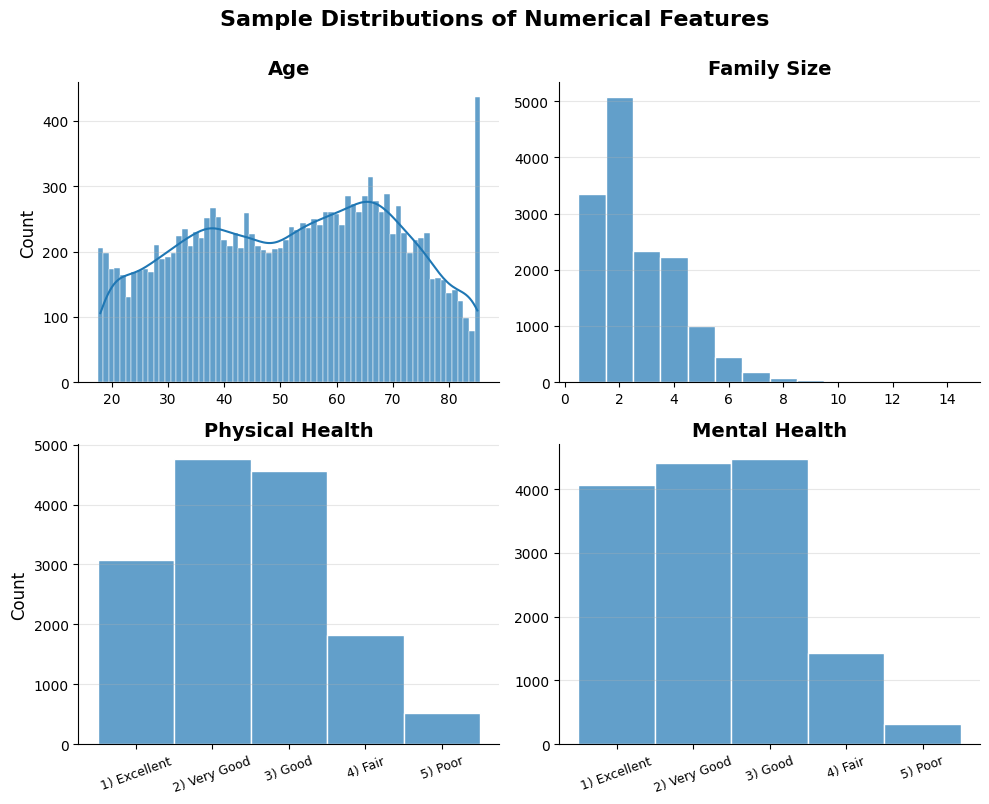

In [72]:
# Sample Distributions (Unweighted)
# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes for easier iteration
axes = axes.flat

# Iterate over all numerical features
for i, feature in enumerate(numerical_features):
    # Get the current axes
    ax = axes[i]

    # Create histogram for the current feature
    sns.histplot(
        data=df, 
        x=feature, 
        ax=ax,
        discrete=True,                               # Centers bars on integers 
        kde=True if feature == "AGE23X" else False,  # Adds a density curve for age
        edgecolor="white",                           # Adds white border lines between bars
        alpha=0.7
    )

    # Customize histogram
    ax.set_title(display_labels[feature], fontsize=14, fontweight="bold") 
    ax.set_xlabel("")
    ax.set_ylabel("Count" if i % 2 == 0 else "", fontsize=12) # Only y-label on left plots
    
    # Set x-axis tick labels for perceived health features
    if feature in ["RTHLTH31", "MNHLTH31"]:
        ax.set_xticks([1, 2, 3, 4, 5])
        ax.set_xticklabels(["1) Excellent", "2) Very Good", "3) Good", "4) Fair", "5) Poor"], fontsize=9, rotation=20)
        
    ax.grid(True, axis="y", alpha=0.3)  # Adds grid lines
    sns.despine(ax=ax)  # Removes top & right spines

# Customize matrix
fig.suptitle("Sample Distributions of Numerical Features", fontsize=16, fontweight="bold", y=1)  # Adds title
fig.tight_layout()  # Adjusts layout to prevent overlap

# Show histogram matrix
plt.show()

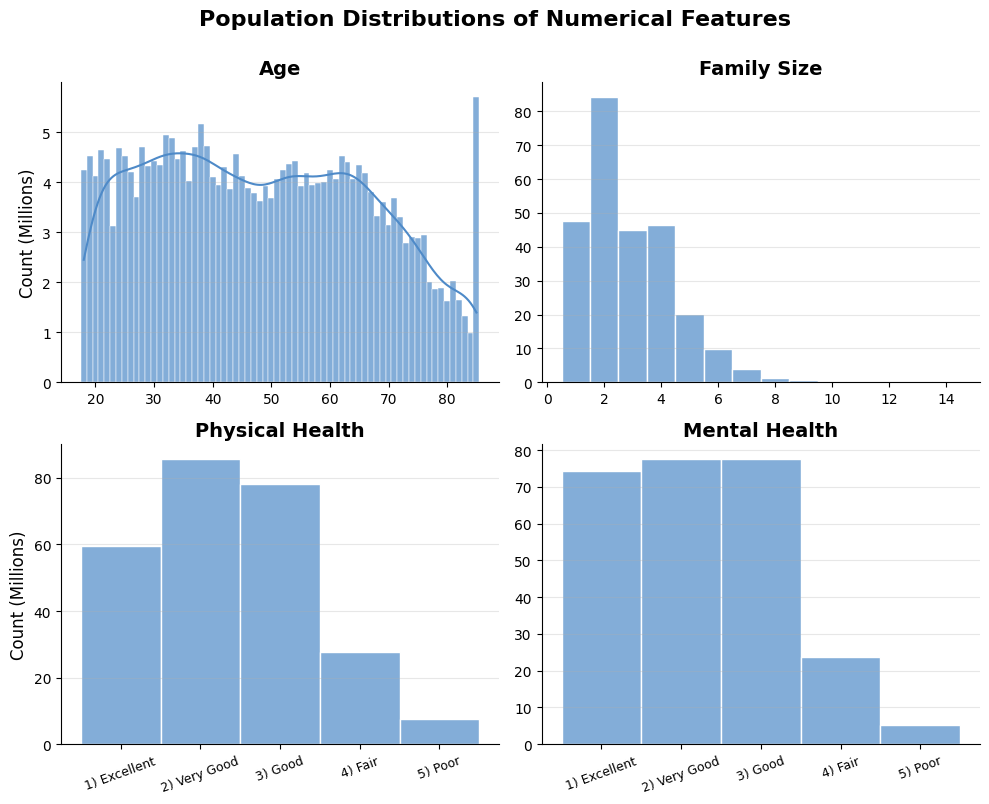

In [71]:
# Population Distributions (Weighted)
# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes for easier iteration
axes = axes.flat

# Iterate over all numerical features
for i, feature in enumerate(numerical_features):
    # Get the current axes
    ax = axes[i]

    # Create weighted histogram for the current feature
    sns.histplot(
        data=df, 
        x=feature,
        weights="PERWT23F",                          # Sample weights
        ax=ax,
        discrete=True,                               # Centers bars on integers 
        kde=True if feature == "AGE23X" else False,  # Adds a density curve for age
        edgecolor="white",                           # Adds white border lines between bars
        alpha=0.7,
        color="#4e8ac8"                              # Different color to distinguish from sample
    )

    # Customize histogram
    ax.set_title(display_labels[feature], fontsize=14, fontweight="bold") 
    ax.set_xlabel("")
    ax.set_ylabel("Count (Millions)" if i % 2 == 0 else "", fontsize=12)     # Only y-label on left plots
    
    # Set x-axis tick labels for perceived health features
    if feature in ["RTHLTH31", "MNHLTH31"]:
        ax.set_xticks([1, 2, 3, 4, 5])
        ax.set_xticklabels(["1) Excellent", "2) Very Good", "3) Good", "4) Fair", "5) Poor"], fontsize=9, rotation=20)
        
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f"{x/1e6:.0f}"))  # Formats y-axis ticks in millions
    ax.grid(True, axis="y", alpha=0.3)  # Adds grid lines
    sns.despine(ax=ax)  # Removes top & right spines

# Customize matrix
fig.suptitle("Population Distributions of Numerical Features", fontsize=16, fontweight="bold", y=1)  # Adds title
fig.tight_layout()  # Adjusts layout to prevent overlap

# Show histogram matrix
plt.show()

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insights: </b>
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Median Imputation Strategy:</b> The right-skewed nature of <code>FAMSZE23</code> and the discrete 1–5 scales of <code>RTHLTH31</code>/<code>MNHLTH31</code> make the median the most robust imputation choice. It prevents exceptionally large families or rare "Poor Health" self-ratings from biasing the central tendency for typical respondents while maintaining scale integrity (imputing observed integers like 2 rather than decimals like 2.4).</li>
        <li><b>Life-Cycle Coverage (Age):</b> The uniform age distribution confirms the dataset adequately represents all adult life stages. The spike at age 85 is a known artifact of top-coding for privacy but represents a significant, high-cost sub-population in the population-level data.</li>
        <li><b>The "Skewed Health" Challenge:</b> While the population is generally healthy (skewed toward 'Excellent' to 'Good'), the relative sparsity of "Fair" or "Poor" health ratings (4–5) creates a challenge. Predicting costs for this critical high-risk segment will depend on a limited number of extreme training samples.</li>
        <li><b>Data Integrity:</b> With missingness below 0.3% across these features, the risk of imputation bias is extremely low. This high data quality allows us to proceed with standard imputation techniques without significant loss of predictive power.</li>
    </ul>
</div>

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Train-Validation-Test Split</h1>
</div>

<div style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px">
    📌 Split the data into 80% for training, 10% for validation, and 10% for testing.
    <br><br>
    <b>Why not a simple random split?</b><br>
    Healthcare costs exhibit a zero-inflated, heavily right-skewed distribution (see <a href="#target-variable"><b>Target Variable EDA</b></a>). The primary risk of a random split in healthcare cost data is the "luck-of-the-draw" misdistribution of super-spenders. Since the extreme tail of the distribution (the top 1%) accounts for a massive share of total population spending, omitting even a few of these individuals from the test set—or over-representing them in the train set—creates catastrophic "metric drift." This makes performance indicators (like R² or MSE) highly volatile and unreliable for predicting real-world financial risk. 
    <br><br>
    <b>Why not a quartile or quintile split?</b><br>
    Standard quartile or quintile bins are too coarse to capture the extreme tail. Because healthcare costs are so concentrated, a quintile-based split (top 20%) would treat a respondent at the 81st percentile (e.g., \$2,000) the same as a "super-spender" at the 99.9th percentile (e.g., \$100,000). Only high-resolution, non-linear strata at the 95th and 99th percentiles can guarantee that these "Black Swan" cases are balanced across all subsets.
    <br><br>
    <b>Distribution-Informed Stratified Split</b><br>
    To ensure the model is evaluated on a representative mirror of the population, I use a distribution-informed stratified split:
    <ul>
        <li><b>Mitigating 'Black Swan' Risks (Primary):</b> Uses high-resolution non-linear bins (80, 95, and 99th percentiles) to force the inclusion of extreme high-cost individuals in all sets, preventing unstable performance metric fluctuations.</li>
        <li><b>Preserving the Zero-Hurdle (Secondary):</b> Guarantees that the 22.3% of zero-cost individuals remain identical across all sets, ensuring consistent evaluation of the model's ability to predict cost occurrence.</li>
        <li><b>Capturing the Pareto Distribution:</b> Prevents evaluation bias by ensuring the 20% of spenders who drive ~80% of the total economic burden are proportionally represented in the test set.</li>
    </ul>
    <b>Strata Distribution</b>
    <table style="margin-left:0; margin-top:20px; margin-bottom:20px">
        <tr>
            <th style="background-color:#f5ecda;">Bin</th>
            <th style="background-color:#f5ecda;">Category</th>
            <th style="background-color:#f5ecda;">Percentile (of Positives)</th>
            <th style="background-color:#f5ecda;">Train (80%)</th>
            <th style="background-color:#f5ecda;">Val (10%)</th>
            <th style="background-color:#f5ecda;">Test (10%)</th>
        </tr>
        <tr>
            <td style="background-color:#fff6e4; text-align:center;"><b>0</b></td>
            <td style="background-color:#fff6e4;">Zero Costs</td>
            <td style="background-color:#fff6e4;">N/A (Hurdle)</td>
            <td style="background-color:#fff6e4; text-align:center;">2,640</td>
            <td style="background-color:#fff6e4; text-align:center;">330</td>
            <td style="background-color:#fff6e4; text-align:center;">330</td>
        </tr>
        <tr>
            <td style="background-color:#f5ecda; text-align:center;"><b>1</b></td>
            <td style="background-color:#f5ecda;">Low Spend</td>
            <td style="background-color:#f5ecda;">0 - 50%</td>
            <td style="background-color:#f5ecda; text-align:center;">4,587</td>
            <td style="background-color:#f5ecda; text-align:center;">573</td>
            <td style="background-color:#f5ecda; text-align:center;">574</td>
        </tr>
        <tr>
            <td style="background-color:#fff6e4; text-align:center;"><b>2</b></td>
            <td style="background-color:#fff6e4;">Moderate</td>
            <td style="background-color:#fff6e4;">50 - 80%</td>
            <td style="background-color:#fff6e4; text-align:center;">2,752</td>
            <td style="background-color:#fff6e4; text-align:center;">344</td>
            <td style="background-color:#fff6e4; text-align:center;">344</td>
        </tr>
        <tr>
            <td style="background-color:#f5ecda; text-align:center;"><b>3</b></td>
            <td style="background-color:#f5ecda;">High Spend</td>
            <td style="background-color:#f5ecda;">80 - 95%</td>
            <td style="background-color:#f5ecda; text-align:center;">1,376</td>
            <td style="background-color:#f5ecda; text-align:center;">172</td>
            <td style="background-color:#f5ecda; text-align:center;">172</td>
        </tr>
        <tr>
            <td style="background-color:#fff6e4; text-align:center;"><b>4</b></td>
            <td style="background-color:#fff6e4;">Very High</td>
            <td style="background-color:#fff6e4;">95 - 99%</td>
            <td style="background-color:#fff6e4; text-align:center;">367</td>
            <td style="background-color:#fff6e4; text-align:center;">46</td>
            <td style="background-color:#fff6e4; text-align:center;">46</td>
        </tr>
        <tr>
            <td style="background-color:#f5ecda; text-align:center;"><b>5</b></td>
            <td style="background-color:#f5ecda;">Massively High</td>
            <td style="background-color:#f5ecda;">99 - 99.9%</td>
            <td style="background-color:#f5ecda; text-align:center;">83</td>
            <td style="background-color:#f5ecda; text-align:center;">10</td>
            <td style="background-color:#f5ecda; text-align:center;">10</td>
        </tr>
        <tr>
            <td style="background-color:#fff6e4; text-align:center;"><b>6</b></td>
            <td style="background-color:#fff6e4;">Super Spenders</td>
            <td style="background-color:#fff6e4;">Top 0.1%</td>
            <td style="background-color:#fff6e4; text-align:center;">12</td>
            <td style="background-color:#fff6e4; text-align:center;">1</td>
            <td style="background-color:#fff6e4; text-align:center;">2</td>
        </tr>
    </table>
</div>

In [ ]:
# Split the data into X features and y target
X = df.drop("TOTSLF23", axis=1)
y = df["TOTSLF23"]

# Helper function for distribution-informed stratification
def create_stratification_bins(y):
    # Initialize strata series 
    strata = pd.Series(index=y.index, dtype=int)
    
    # Bin 0: Zero Costs (Handle the hurdle separately)
    is_zero = (y == 0)
    strata[is_zero] = 0
    
    # Custom non-linear quantiles for positive values to capture the tail
    positive_y = y[~is_zero]
    bins = [0, 0.5, 0.8, 0.95, 0.99, 0.999, 1.0]
    
    # Assign positive spenders to bins 1 through 5 
    # Note: labels=False returns the bin indices (0-4) instead of Interval objects (e.g., [0, 150.5]). We add 1 to shift the indices to 1-5 with 0 being reserved for the zero cost bin.
    # Note: duplicates="drop" avoids errors if multiple quantiles (e.g., 0.95 and 0.99) result in the same cost value.
    strata[~is_zero] = pd.qcut(positive_y, q=bins, labels=False, duplicates="drop") + 1
    return strata

# Generate the stratification column 
y_strata = create_stratification_bins(y)

# Perform the first distribution-informed stratified split (80% Train, 20% Temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y_strata
)

# Re-calculate strata for the temporary set to ensure the 50/50 split is also representative
temp_strata = create_stratification_bins(y_temp)

# Perform the second stratified split (resulting in 10% Val, 10% Test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=temp_strata
)

# Helper function to verify the stratification splits
def verify_split(y_subset, y_subset_strata, name):
    # Calculate relative frequencies of the bins
    strata_freq = y_subset_strata.value_counts(normalize=True).sort_index() * 100
    
    # Calculate key distribution metrics
    stats = {
        "Samples": len(y_subset),
        "Mean Cost": y_subset.mean(),
        "Median Cost": y_subset.median(),
        "Max Cost": y_subset.max()
    }
    
    # Merge metrics and strata proportions 
    for i, freq in strata_freq.items():
        stats[f"Bin {int(i)}"] = freq
        
    return pd.Series(stats, name=name)

# Create DataFrame of split verification statistics
split_verification_df = pd.concat([
    verify_split(y, y_strata, "Total Dataset"),
    verify_split(y_train, y_strata.loc[y_train.index], "Train (80%)"),
    verify_split(y_val, y_strata.loc[y_val.index], "Validation (10%)"),
    verify_split(y_test, y_strata.loc[y_test.index], "Test (10%)")
], axis=1).T

# Delete temporary variables to free up memory
del X_temp, y_temp, temp_strata, y_strata

# Display the verification DataFrame (format for readability) 
split_verification_df.style.format("{:,.1f}") \
            .format("{:,.0f}", subset=["Samples", "Max Cost"]) \
            .format("${:,.0f}", subset=["Mean Cost", "Median Cost", "Max Cost"]) \
            .format("{:.2f}%", subset=["Bin 0", "Bin 1", "Bin 2", "Bin 3", "Bin 4", "Bin 5", "Bin 6"])

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> The distribution-informed stratification successfully created representative and robust data splits.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>Structural Precision:</b> Relative frequencies of all strata (Bins 0–6) are near-perfectly preserved across all splits, ensuring that the zero-inflation and the Pareto-style concentration are balanced.</li>
        <li><b>Mitigation of "Metric Drift":</b> By forcing the inclusion of extreme high-cost individuals (99.9th percentile) in the Test set, we prevent "luck-of-the-draw" bias and ensure that performance metrics (e.g., R²) are robust against catastrophic outliers.</li>
        <li><b>Representative Benchmarking:</b> The stability of central tendencies (Median Cost) confirms that the typical patient profile is identical in each set, allowing for reliable and generalizable model evaluation.</li>
    </ul>
</div>

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Data Preprocessing</h1>
</div> 

<div style="background-color:#e8f4fd; padding:15px; border:3px solid #d0e7fa; border-radius:6px;">
    ℹ️ Perform feature engineering and preprocess the data for machine learning.
</div>

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Handling Missing Values</h2>
</div> 

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Identification</strong> <br>
    📌 Identify missing values.
</div>

In [ ]:
# Create a summary table for missing values
missing_value_df = pd.DataFrame({
    "Training": X_train.isnull().sum(),
    "Validation": X_val.isnull().sum(),
    "Test": X_test.isnull().sum(),
})
# Add target variable missings
missing_value_df.loc["TOTSLF23"] = [
    y_train.isnull().sum(),
    y_val.isnull().sum(),
    y_test.isnull().sum(),
]
# Display table (sorted and with percentages)
missing_value_df.sort_values("Training", ascending=False).style.format({
    "Training": lambda x: f"{x} ({x / len(X_train) * 100:.1f}%)",
    "Validation": lambda x: f"{x} ({x / len(X_val) * 100:.1f}%)",
    "Test": lambda x: f"{x} ({x / len(X_test) * 100:.1f}%)"
})

<div style="background-color:#f7fff8; padding:15px; border:3px solid #e0f0e0; border-radius:6px;">
    💡 <b>Insight:</b> Missing value analysis reveals a high level of data integrity and consistency across all splits.
    <ul style="margin-top:10px; margin-bottom:0px">
        <li><b>High Data Quality:</b> Missingness is quite low (Maximum ~3.8% for Usual Source of Care), with most features well below 1%, minimizing the risk of imputation bias.</li>
        <li><b>Consistent Splits:</b> Missing value frequencies are near-identical across Training, Validation, and Test sets, suggesting the stratification did not introduce feature bias.</li>
        <li><b>Key Variable Completeness:</b> Expected cost drivers such as Age, Sex, Region, Poverty Status, Insurance, and the Target Variable are 100% complete.</li>
        <li><b>Implication for App Design:</b> The 100% completeness of demographics justifies making them required in the app, while high completeness allows us to safely treat unchecked boxes as an explicit "No" (0) rather than a missing value.</li>
    </ul>
</div>

<div style="background-color:#fff6e4; padding:15px; border:3px solid #f5ecda; border-radius:6px;">
    <strong>Imputation</strong> <br>
    📌 Impute missing values. Use the median for numerical features and the mode (most frequent value) for categorical features.
</div>

In [ ]:
# Calculate median for each numerical feature from training data
medians = X_train[numerical_features].median()

# Impute median in training, validation, and test data
X_train[numerical_features] = X_train[numerical_features].fillna(medians)
X_val[numerical_features] = X_val[numerical_features].fillna(medians)
X_test[numerical_features] = X_test[numerical_features].fillna(medians)

# Verify results
pd.DataFrame({
    "Training": X_train[numerical_features].isnull().sum(),
    "Validation": X_val[numerical_features].isnull().sum(),
    "Test": X_test[numerical_features].isnull().sum(),
})

In [ ]:
# Calculate mode for each categorical feature from training data
modes = X_train[categorical_features].mode().loc[0]

# Impute mode in training, validation, and test data
X_train[categorical_features] = X_train[categorical_features].fillna(modes)
X_val[categorical_features] = X_val[categorical_features].fillna(modes)
X_test[categorical_features] = X_test[categorical_features].fillna(modes)

# Verify results
pd.DataFrame({
    "Training": X_train[categorical_features].isnull().sum(),
    "Validation": X_val[categorical_features].isnull().sum(),
    "Test": X_test[categorical_features].isnull().sum(),
})

<div style="background-color:#3d7ab3; color:white; padding:12px; border-radius:6px;">
    <h2 style="margin:0px">Handling Outliers</h2>
</div>

<div style="background-color:#4e8ac8; color:white; padding:10px; border-radius:6px;">
    <h3 style="margin:0px">3SD Method</h3>
</div>

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> 📌 Identify and remove univariate outliers in numerical columns by applying the 3 standard deviation rule (3SD). A data point is considered an outlier if it falls more than 3 standard deviations above or below the mean of the column.</p> 

In [ ]:
# Custom scikit-learn transformer class to identify and remove outliers using the 3SD method
class OutlierRemover3SD(BaseEstimator, TransformerMixin):
    def fit(self, df, numerical_columns):
        # Convert single column string to list
        if isinstance(numerical_columns, str):
            self.numerical_columns_ = [numerical_columns]
        else:
            self.numerical_columns_ = numerical_columns
            
        # Calculate statistics (mean, std, cutoff values) for each column
        self.stats_ = pd.DataFrame(index=self.numerical_columns_)
        self.stats_["mean"] = df[self.numerical_columns_].mean()
        self.stats_["std"] = df[self.numerical_columns_].std()
        self.stats_["lower_cutoff"] = self.stats_["mean"] - 3 * self.stats_["std"]
        self.stats_["upper_cutoff"] = self.stats_["mean"] + 3 * self.stats_["std"]
        
        # Create masks for filtering outliers 
        self.masks_ = (df[self.numerical_columns_] >= self.stats_["lower_cutoff"]) & (df[self.numerical_columns_] <= self.stats_["upper_cutoff"])  # masks by column
        self.final_mask_ = self.masks_.all(axis=1)  # single mask across all columns
     
        # Calculate number of outliers
        self.stats_["n_outliers"] = (~self.masks_).sum()  # by column
        self.stats_["pct_outliers"] = self.stats_["n_outliers"] / len(df) * 100  # by column
        self.outliers_ = (~self.final_mask_).sum()  # across all columns
        
        return self

    def transform(self, df):
        # Create masks for df (can be a different df than during fit; e.g. X_train, X_test)
        self.masks_ = (df[self.numerical_columns_] >= self.stats_["lower_cutoff"]) & (df[self.numerical_columns_] <= self.stats_["upper_cutoff"])  # masks by column
        self.final_mask_ = self.masks_.all(axis=1)  # single mask across all columns
        
        # Remove outliers based on the final mask
        return df[self.final_mask_]

    def fit_transform(self, df, numerical_columns):
        # Perform both fit and transform 
        return self.fit(df, numerical_columns).transform(df)


# Initialize outlier remover 
outlier_remover_3sd = OutlierRemover3SD()

# Fit outlier remover to training data
outlier_remover_3sd.fit(X_train, numerical_features)

# Show outliers in training data
print(f"Training Data: Identified {outlier_remover_3sd.outliers_} rows ({outlier_remover_3sd.outliers_ / len(outlier_remover_3sd.final_mask_) * 100:.1f}%) with outliers.\n")
print("Outlier statistics by column:")
outlier_remover_3sd.stats_.style.format({
    "mean": "{:.2f}",
    "std": "{:.2f}",
    "lower_cutoff": "{:.2f}",
    "upper_cutoff": "{:.2f}",
    "n_outliers": "{:.0f}",
    "pct_outliers": "{:.1f}%"
})

<div style="background-color:#4e8ac8; color:white; padding:10px; border-radius:6px;">
    <h3 style="margin:0px">1.5 IQR Method </h3>
</div> 

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> 📌 Identify and remove univariate outliers in numerical columns using the 1.5 interquartile range (IQR) rule. A data point is considered an outlier if it falls more than 1.5 interquartile ranges above the third quartile (Q3) or below the first quartile (Q1) of the column.</p> 

In [ ]:
# Custom scikit-learn transformer class to identify and remove outliers using the 1.5 IQR method
class OutlierRemoverIQR(BaseEstimator, TransformerMixin):
    def fit(self, df, numerical_columns):
        # Convert single column string to list
        if isinstance(numerical_columns, str):
            self.numerical_columns_ = [numerical_columns]
        else:
            self.numerical_columns_ = numerical_columns
        
        # Calculate statistics (quartiles, interquartile range, cutoff values) for each column
        self.stats_ = pd.DataFrame(index=self.numerical_columns_)
        self.stats_["Q1"] = df[self.numerical_columns_].quantile(0.25)
        self.stats_["Q3"] = df[self.numerical_columns_].quantile(0.75)
        self.stats_["IQR"] = self.stats_["Q3"] - self.stats_["Q1"]
        self.stats_["lower_cutoff"] = self.stats_["Q1"] - 1.5 * self.stats_["IQR"]
        self.stats_["upper_cutoff"] = self.stats_["Q3"] + 1.5 * self.stats_["IQR"]

        # Create masks for filtering outliers 
        self.masks_ = (df[self.numerical_columns_] >= self.stats_["lower_cutoff"]) & (df[self.numerical_columns_] <= self.stats_["upper_cutoff"])  # masks by column
        self.final_mask_ = self.masks_.all(axis=1)  # single mask across all columns

        # Calculate number of outliers
        self.stats_["n_outliers"] = (~self.masks_).sum()  # by column
        self.stats_["pct_outliers"] = self.stats_["n_outliers"] / len(df) * 100  # by column
        self.outliers_ = (~self.final_mask_).sum()  # across all columns
               
        return self

    def transform(self, df):
        # Create masks for df (can be a different df than during fit; e.g. X_train, X_test)
        self.masks_ = (df[self.numerical_columns_] >= self.stats_["lower_cutoff"]) & (df[self.numerical_columns_] <= self.stats_["upper_cutoff"])  # masks by column
        self.final_mask_ = self.masks_.all(axis=1)  # single mask across all columns
        
        # Remove outliers based on the final mask
        return df[self.final_mask_]

    def fit_transform(self, df, numerical_columns):
        # Perform both fit and transform
        return self.fit(df, numerical_columns).transform(df)


# Initialize outlier remover 
outlier_remover_iqr = OutlierRemoverIQR()

# Fit outlier remover to training data
outlier_remover_iqr.fit(X_train, numerical_features)

# Show outliers by column for training data
print(f"Training Data: Identified {outlier_remover_iqr.outliers_} rows ({outlier_remover_iqr.outliers_ / len(outlier_remover_iqr.final_mask_) * 100:.1f}%) with outliers.\n")
print("Outliers statistics by column:")
outlier_remover_iqr.stats_.style.format({
    "Q1": "{:.1f}",
    "Q3": "{:.1f}",
    "IQR": "{:.1f}",
    "lower_cutoff": "{:.1f}",
    "upper_cutoff": "{:.1f}",
    "n_outliers": "{:.0f}",
    "pct_outliers": "{:.1f}%"
})

<div style="background-color:#2c699d; color:white; padding:15px; border-radius:6px;">
    <h1 style="margin:0px">Summary</h1>
</div> 

- **Data Loading**: Imported MEPS-HC 2023 SAS data using `pandas` `read_sas`.
- **Handling Duplicates**: Verified the absence of duplicates based on the ID column, complete rows, and all columns except ID.
- **Variable Selection**: Filtered 29 essential columns (target variable, candidate features, ID, sample weights) from the original 1,374 columns.
- **Target Population Filtering**: Filtered rows for adults with positive person weights (14,768 out of 18,919 respondents).
- **Handling Data Types**: Converted ID to string and maintained features and target as floats to ensure compatibility with scikit-learn transformers and models. Defined semantic data types for all features (numerical, binary, nominal, ordinal).
- **Standardizing Missing Values**: Recovered values from survey skip patterns and converted MEPS-specific missing codes to `np.nan`.
- **Train-Validation-Test Split**: Split data into training (80%), validation (10%), and test (10%) sets using a distribution-informed stratified split to balance zero-inflation and extreme tail of the target variable.